In [2]:
import VisionTransformer as ViT
import ImageFolderDatasetLoader as DatasetLoader
import Trainer as Trainer

import torch
from torch import nn, optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms
from torchinfo import summary

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Vision Transformer

In [24]:
vit = ViT.ViT(img_size=128,
          in_channels=3, 
          patch_size=16,
          num_transformer_layers=12, 
          embedding_dim=256,
          mlp_size=1024,
          num_heads=8,
          value_dim=64,
          key_dim=64,
          attn_dropout=0.1,
          mlp_dropout=0.1,
          embedding_dropout=0.1,
          num_classes=4)

In [25]:
summary(model=vit,
        input_size=(32, 3, 128, 128),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [32, 3, 128, 128]    [32, 4]              16,896               True
├─PatchEmbedding (patch_embedding)                      [32, 3, 128, 128]    [32, 64, 256]        --                   True
│    └─Conv2d (patcher)                                 [32, 3, 128, 128]    [32, 256, 8, 8]      196,864              True
│    └─Flatten (flatten)                                [32, 256, 8, 8]      [32, 256, 64]        --                   --
├─Dropout (embedding_dropout)                           [32, 65, 256]        [32, 65, 256]        --                   --
├─ModuleList (transformer_encoder)                      --                   --                   --                   True
│    └─TransformerEncoderBlock (0)                      [32, 65, 256]        [32, 65, 256]        --                   True
│    │ 

# Dataset Loading and Analysis

In [4]:
#root_dir = "D:\\Research\\Image Classification\\Aerial Landscape Images Dataset" 
root_dir = "D:\Research\Image Classification\Brain Tumor Dataset"
batch_size = 32
image_size = (128, 128)

mean = torch.tensor([0.2104, 0.2104, 0.2104])
std = torch.tensor([0.1873, 0.1873, 0.1873])

train_transforms = transforms.Compose([
    transforms.Resize(image_size),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 15)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    #transforms.RandomSolarize(threshold=192.0),
    transforms.RandomAdjustSharpness(sharpness_factor=1.2),
    transforms.RandomAutocontrast(p=0.5),
    transforms.RandomEqualize(p=0.5),                            
    transforms.ToTensor(), 
    #transforms.Normalize(mean=[0.3779, 0.3927, 0.3443], std=[0.1356, 0.1234, 0.1182]) # Aerial Landscape Dataset
    transforms.Normalize(mean=[0.2104, 0.2104, 0.2104], std=[0.1873, 0.1873, 0.1873]) # Brain Tumor Dataset
])

test_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.2104, 0.2104, 0.2104], std=[0.1873, 0.1873, 0.1873])
])

loader = DatasetLoader.ImageFolderDatasetLoader(root_dir, batch_size=batch_size, transforms=None, seed=seed)
train_loader, test_loader = loader.get_train_test_loader(test_size=0.2, train_transforms=train_transforms, test_transforms=test_transforms)

## Visualization of Training Images

In [5]:
def imshow(images, labels, num_images, names, mean, std):
    indices = torch.randperm(images.size(0))[:num_images]
    
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        
        img = images[idx].clone()
        img = img.mul_(std[:, None, None]).add_(mean[:, None, None])
        
        plt.imshow(img.permute(1, 2, 0) )
        plt.title(names[labels[idx].item()])
        plt.axis('off')

    plt.show()


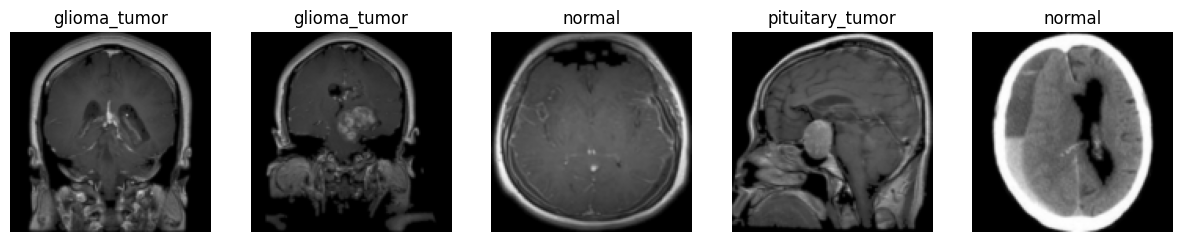

In [28]:
num_images = 5
names = loader.get_label_to_name()
images, labels = next(iter(train_loader))

imshow(images, labels, num_images, names, mean, std)

## Class Distribution in Training Set

In [13]:
def get_class_distribution(data_loader):
    return Counter([data_loader.dataset.dataset.samples[idx][1] for idx in data_loader.dataset.indices])

def get_sorted_class_names_and_frequencies(distribution, name_mapper):
    labels = list(distribution.keys())
    frequencies = list(distribution.values())
    
    class_names = [name_mapper[label] for label in labels]
    
    sorted_indices = sorted(range(len(class_names)), key=lambda i: class_names[i])
    sorted_class_names = [class_names[i] for i in sorted_indices]
    sorted_frequencies = [frequencies[i] for i in sorted_indices]
    
    return sorted_class_names, sorted_frequencies

def plot_class_distribution(class_names, frequencies):

    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_names, frequencies, color='skyblue')

    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

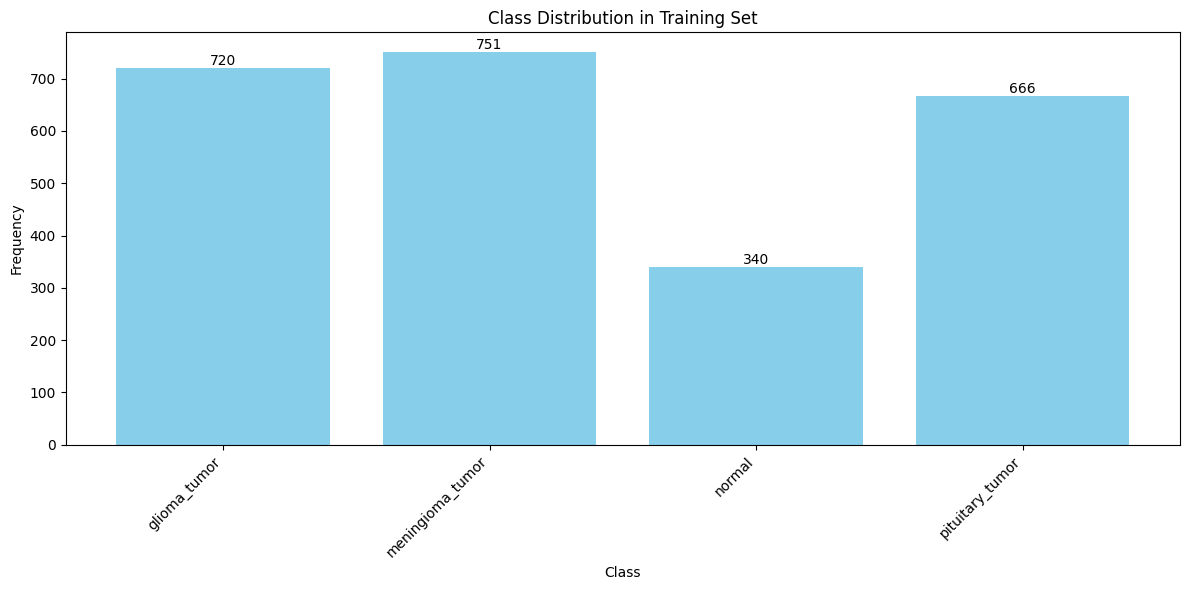

In [30]:
train_distribution = get_class_distribution(train_loader)
names = loader.get_label_to_name()
class_names, frequencies = get_sorted_class_names_and_frequencies(train_distribution, names)
plot_class_distribution(class_names, frequencies)

# Training

In [31]:
learning_rate = 0.00001
weight_decay = 0.01
loss_fn = nn.CrossEntropyLoss()
model_name = "model"

optimizer = optim.AdamW(vit.parameters(), lr=learning_rate, weight_decay=weight_decay)
trainer = Trainer.Trainer(vit, optimizer, loss_fn, model_name=model_name, device=device, patience=30)

In [32]:
trainer.train(train_loader, test_loader, epochs=500)

Training Epoch: 100%|██████████| 78/78 [02:40<00:00,  2.06s/batch, loss=1.25]


Epoch: 1, Train loss: 1.3072, Test loss: 1.2409, Test Accuracy: 0.4782
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:37<00:00,  2.02s/batch, loss=1.2]  


Epoch: 2, Train loss: 1.2212, Test loss: 1.1325, Test Accuracy: 0.5089
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:37<00:00,  2.02s/batch, loss=1.22] 


Epoch: 3, Train loss: 1.1569, Test loss: 1.0687, Test Accuracy: 0.5412
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:37<00:00,  2.02s/batch, loss=1.04] 


Epoch: 4, Train loss: 1.1203, Test loss: 1.0579, Test Accuracy: 0.5525
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:42<00:00,  2.08s/batch, loss=1.13] 


Epoch: 5, Train loss: 1.0918, Test loss: 1.0409, Test Accuracy: 0.5283


Training Epoch: 100%|██████████| 78/78 [02:37<00:00,  2.01s/batch, loss=0.827]


Epoch: 6, Train loss: 1.0724, Test loss: 1.0239, Test Accuracy: 0.5525


Training Epoch: 100%|██████████| 78/78 [02:37<00:00,  2.01s/batch, loss=0.684]


Epoch: 7, Train loss: 1.0329, Test loss: 0.9847, Test Accuracy: 0.5897
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:37<00:00,  2.02s/batch, loss=1.34] 


Epoch: 8, Train loss: 1.0190, Test loss: 0.9840, Test Accuracy: 0.5622


Training Epoch: 100%|██████████| 78/78 [02:37<00:00,  2.02s/batch, loss=0.832]


Epoch: 9, Train loss: 0.9582, Test loss: 1.1550, Test Accuracy: 0.5347


Training Epoch: 100%|██████████| 78/78 [02:36<00:00,  2.00s/batch, loss=0.905]


Epoch: 10, Train loss: 0.9145, Test loss: 0.7704, Test Accuracy: 0.6898
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:37<00:00,  2.02s/batch, loss=0.851]


Epoch: 11, Train loss: 0.8907, Test loss: 0.7591, Test Accuracy: 0.6817


Training Epoch: 100%|██████████| 78/78 [02:36<00:00,  2.01s/batch, loss=0.807]


Epoch: 12, Train loss: 0.8467, Test loss: 0.8713, Test Accuracy: 0.6268


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.945]


Epoch: 13, Train loss: 0.8241, Test loss: 0.7779, Test Accuracy: 0.6785


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=1.31] 


Epoch: 14, Train loss: 0.8003, Test loss: 0.7294, Test Accuracy: 0.6817


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  2.00s/batch, loss=0.772]


Epoch: 15, Train loss: 0.7940, Test loss: 0.7650, Test Accuracy: 0.6737


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=1.02] 


Epoch: 16, Train loss: 0.7728, Test loss: 0.7961, Test Accuracy: 0.6801


Training Epoch: 100%|██████████| 78/78 [02:38<00:00,  2.03s/batch, loss=1.19] 


Epoch: 17, Train loss: 0.7523, Test loss: 0.7458, Test Accuracy: 0.6866


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=1.27] 


Epoch: 18, Train loss: 0.7482, Test loss: 0.6456, Test Accuracy: 0.7302
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:36<00:00,  2.01s/batch, loss=0.282]


Epoch: 19, Train loss: 0.7041, Test loss: 0.6861, Test Accuracy: 0.7141


Training Epoch: 100%|██████████| 78/78 [02:38<00:00,  2.03s/batch, loss=0.786]


Epoch: 20, Train loss: 0.7034, Test loss: 0.7306, Test Accuracy: 0.6995


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.463]


Epoch: 21, Train loss: 0.6968, Test loss: 0.8531, Test Accuracy: 0.6721


Training Epoch: 100%|██████████| 78/78 [02:37<00:00,  2.02s/batch, loss=0.928]


Epoch: 22, Train loss: 0.6732, Test loss: 0.6897, Test Accuracy: 0.7480
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:36<00:00,  2.01s/batch, loss=0.482]


Epoch: 23, Train loss: 0.6761, Test loss: 0.6286, Test Accuracy: 0.7544
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:37<00:00,  2.02s/batch, loss=0.557]


Epoch: 24, Train loss: 0.6687, Test loss: 0.6399, Test Accuracy: 0.7496


Training Epoch: 100%|██████████| 78/78 [02:36<00:00,  2.00s/batch, loss=1.23] 


Epoch: 25, Train loss: 0.6464, Test loss: 0.6484, Test Accuracy: 0.7480


Training Epoch: 100%|██████████| 78/78 [02:36<00:00,  2.01s/batch, loss=0.723]


Epoch: 26, Train loss: 0.6291, Test loss: 0.7087, Test Accuracy: 0.7286


Training Epoch: 100%|██████████| 78/78 [02:41<00:00,  2.07s/batch, loss=0.881]


Epoch: 27, Train loss: 0.6204, Test loss: 0.6117, Test Accuracy: 0.7754
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.703]


Epoch: 28, Train loss: 0.6174, Test loss: 0.6620, Test Accuracy: 0.7577


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=1.06] 


Epoch: 29, Train loss: 0.6053, Test loss: 0.7726, Test Accuracy: 0.7205


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.693]


Epoch: 30, Train loss: 0.5859, Test loss: 0.7747, Test Accuracy: 0.7060


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.557]


Epoch: 31, Train loss: 0.5842, Test loss: 0.6222, Test Accuracy: 0.7641


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.476]


Epoch: 32, Train loss: 0.5655, Test loss: 0.6767, Test Accuracy: 0.7447


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.37] 


Epoch: 33, Train loss: 0.5419, Test loss: 0.6158, Test Accuracy: 0.7803
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.907]


Epoch: 34, Train loss: 0.5485, Test loss: 0.6457, Test Accuracy: 0.7625


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.474]


Epoch: 35, Train loss: 0.5561, Test loss: 0.6286, Test Accuracy: 0.7803


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.235]


Epoch: 36, Train loss: 0.5428, Test loss: 0.6538, Test Accuracy: 0.7399


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.549]


Epoch: 37, Train loss: 0.5302, Test loss: 0.7031, Test Accuracy: 0.7415


Training Epoch: 100%|██████████| 78/78 [02:33<00:00,  1.97s/batch, loss=0.335]


Epoch: 38, Train loss: 0.5184, Test loss: 0.6309, Test Accuracy: 0.7771


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.431]


Epoch: 39, Train loss: 0.5108, Test loss: 0.6280, Test Accuracy: 0.7787


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.395]


Epoch: 40, Train loss: 0.4858, Test loss: 0.6165, Test Accuracy: 0.7787


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.4]  


Epoch: 41, Train loss: 0.4864, Test loss: 0.5960, Test Accuracy: 0.7916
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.383]


Epoch: 42, Train loss: 0.4912, Test loss: 0.6587, Test Accuracy: 0.7674


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.165]


Epoch: 43, Train loss: 0.4732, Test loss: 0.6276, Test Accuracy: 0.7932
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.258]


Epoch: 44, Train loss: 0.4722, Test loss: 0.6691, Test Accuracy: 0.7674


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.437]


Epoch: 45, Train loss: 0.4586, Test loss: 0.6396, Test Accuracy: 0.7722


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.222]


Epoch: 46, Train loss: 0.4469, Test loss: 0.6489, Test Accuracy: 0.7706


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.385]


Epoch: 47, Train loss: 0.4513, Test loss: 0.6023, Test Accuracy: 0.7948
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.133]


Epoch: 48, Train loss: 0.4357, Test loss: 0.6559, Test Accuracy: 0.7738


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  2.00s/batch, loss=0.695]


Epoch: 49, Train loss: 0.4385, Test loss: 0.5510, Test Accuracy: 0.8094
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:37<00:00,  2.02s/batch, loss=0.232]


Epoch: 50, Train loss: 0.4149, Test loss: 0.6001, Test Accuracy: 0.7900


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.102]


Epoch: 51, Train loss: 0.4092, Test loss: 0.6195, Test Accuracy: 0.7932


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.419]


Epoch: 52, Train loss: 0.4046, Test loss: 0.5789, Test Accuracy: 0.8061


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.455]


Epoch: 53, Train loss: 0.3825, Test loss: 0.6268, Test Accuracy: 0.7964


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.507]


Epoch: 54, Train loss: 0.3756, Test loss: 0.6321, Test Accuracy: 0.7803


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.364]


Epoch: 55, Train loss: 0.3811, Test loss: 0.6429, Test Accuracy: 0.7819


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.381]


Epoch: 56, Train loss: 0.3911, Test loss: 0.7649, Test Accuracy: 0.7399


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.495]


Epoch: 57, Train loss: 0.3769, Test loss: 0.5613, Test Accuracy: 0.8110
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.22] 


Epoch: 58, Train loss: 0.3464, Test loss: 0.6269, Test Accuracy: 0.8029


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.468]


Epoch: 59, Train loss: 0.3603, Test loss: 0.5776, Test Accuracy: 0.8110


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.229]


Epoch: 60, Train loss: 0.3744, Test loss: 0.6729, Test Accuracy: 0.7706


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.305]


Epoch: 61, Train loss: 0.3254, Test loss: 0.5924, Test Accuracy: 0.8078


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.236]


Epoch: 62, Train loss: 0.3277, Test loss: 0.5637, Test Accuracy: 0.8304
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.208]


Epoch: 63, Train loss: 0.3489, Test loss: 0.5926, Test Accuracy: 0.8013


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.3]  


Epoch: 64, Train loss: 0.3187, Test loss: 0.6454, Test Accuracy: 0.8029


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.186]


Epoch: 65, Train loss: 0.3220, Test loss: 0.6027, Test Accuracy: 0.8110


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.298]


Epoch: 66, Train loss: 0.3190, Test loss: 0.5398, Test Accuracy: 0.8433
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0524]


Epoch: 67, Train loss: 0.2923, Test loss: 0.5786, Test Accuracy: 0.8207


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.403]


Epoch: 68, Train loss: 0.2835, Test loss: 0.5620, Test Accuracy: 0.8158


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.18] 


Epoch: 69, Train loss: 0.2716, Test loss: 0.6603, Test Accuracy: 0.8126


Training Epoch: 100%|██████████| 78/78 [02:38<00:00,  2.03s/batch, loss=0.243] 


Epoch: 70, Train loss: 0.2683, Test loss: 0.5254, Test Accuracy: 0.8352


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.373] 


Epoch: 71, Train loss: 0.2647, Test loss: 0.5443, Test Accuracy: 0.8465
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0923]


Epoch: 72, Train loss: 0.2582, Test loss: 0.5885, Test Accuracy: 0.8239


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.8]  


Epoch: 73, Train loss: 0.2934, Test loss: 0.6042, Test Accuracy: 0.8158


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.155] 


Epoch: 74, Train loss: 0.2611, Test loss: 0.5607, Test Accuracy: 0.8530
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.207] 


Epoch: 75, Train loss: 0.2569, Test loss: 0.5932, Test Accuracy: 0.8207


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.139] 


Epoch: 76, Train loss: 0.2440, Test loss: 0.5661, Test Accuracy: 0.8368


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.154] 


Epoch: 77, Train loss: 0.2320, Test loss: 0.5832, Test Accuracy: 0.8207


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.192] 


Epoch: 78, Train loss: 0.2376, Test loss: 0.5152, Test Accuracy: 0.8578
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0655]


Epoch: 79, Train loss: 0.2388, Test loss: 0.5423, Test Accuracy: 0.8546


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.124] 


Epoch: 80, Train loss: 0.2250, Test loss: 0.5625, Test Accuracy: 0.8352


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.344] 


Epoch: 81, Train loss: 0.2129, Test loss: 0.7158, Test Accuracy: 0.8061


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.273] 


Epoch: 82, Train loss: 0.2350, Test loss: 0.5196, Test Accuracy: 0.8530


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.287] 


Epoch: 83, Train loss: 0.2081, Test loss: 0.5394, Test Accuracy: 0.8562


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.193] 


Epoch: 84, Train loss: 0.2336, Test loss: 0.5795, Test Accuracy: 0.8465


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.336] 


Epoch: 85, Train loss: 0.2079, Test loss: 0.5560, Test Accuracy: 0.8384


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0754]


Epoch: 86, Train loss: 0.1990, Test loss: 0.5694, Test Accuracy: 0.8481


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.274] 


Epoch: 87, Train loss: 0.1828, Test loss: 0.5529, Test Accuracy: 0.8481


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.39]  


Epoch: 88, Train loss: 0.1781, Test loss: 0.5566, Test Accuracy: 0.8659
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.295] 


Epoch: 89, Train loss: 0.1883, Test loss: 0.5781, Test Accuracy: 0.8562


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.386] 


Epoch: 90, Train loss: 0.1719, Test loss: 0.5847, Test Accuracy: 0.8514


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0741]


Epoch: 91, Train loss: 0.1829, Test loss: 0.5797, Test Accuracy: 0.8336


Training Epoch: 100%|██████████| 78/78 [02:38<00:00,  2.03s/batch, loss=0.125] 


Epoch: 92, Train loss: 0.1750, Test loss: 0.5450, Test Accuracy: 0.8498


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.0617]


Epoch: 93, Train loss: 0.1855, Test loss: 0.5430, Test Accuracy: 0.8611


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.132] 


Epoch: 94, Train loss: 0.1535, Test loss: 0.6039, Test Accuracy: 0.8514


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.06]  


Epoch: 95, Train loss: 0.1644, Test loss: 0.5985, Test Accuracy: 0.8433


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.205] 


Epoch: 96, Train loss: 0.1572, Test loss: 0.6760, Test Accuracy: 0.8320


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.228] 


Epoch: 97, Train loss: 0.1693, Test loss: 0.5761, Test Accuracy: 0.8595


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.257] 


Epoch: 98, Train loss: 0.1493, Test loss: 0.5485, Test Accuracy: 0.8627


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.176] 


Epoch: 99, Train loss: 0.1506, Test loss: 0.5345, Test Accuracy: 0.8562


Training Epoch: 100%|██████████| 78/78 [02:33<00:00,  1.97s/batch, loss=0.444] 


Epoch: 100, Train loss: 0.1333, Test loss: 0.6402, Test Accuracy: 0.8320


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.26]  


Epoch: 101, Train loss: 0.1326, Test loss: 0.5507, Test Accuracy: 0.8627


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0648]


Epoch: 102, Train loss: 0.1539, Test loss: 0.5568, Test Accuracy: 0.8627


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.135] 


Epoch: 103, Train loss: 0.1347, Test loss: 0.5705, Test Accuracy: 0.8708
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.124] 


Epoch: 104, Train loss: 0.1279, Test loss: 0.5782, Test Accuracy: 0.8627


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.244] 


Epoch: 105, Train loss: 0.1226, Test loss: 0.6332, Test Accuracy: 0.8465


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0509]


Epoch: 106, Train loss: 0.1247, Test loss: 0.6165, Test Accuracy: 0.8465


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.0749]


Epoch: 107, Train loss: 0.1329, Test loss: 0.6604, Test Accuracy: 0.8320


Training Epoch: 100%|██████████| 78/78 [02:33<00:00,  1.97s/batch, loss=0.0315]


Epoch: 108, Train loss: 0.1357, Test loss: 0.5772, Test Accuracy: 0.8578


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.0991]


Epoch: 109, Train loss: 0.1203, Test loss: 0.6155, Test Accuracy: 0.8595


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00737]


Epoch: 110, Train loss: 0.1127, Test loss: 0.5919, Test Accuracy: 0.8578


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0258]


Epoch: 111, Train loss: 0.1209, Test loss: 0.6444, Test Accuracy: 0.8465


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.0114]


Epoch: 112, Train loss: 0.1174, Test loss: 0.6373, Test Accuracy: 0.8562


Training Epoch: 100%|██████████| 78/78 [02:33<00:00,  1.97s/batch, loss=0.0636] 


Epoch: 113, Train loss: 0.1198, Test loss: 0.6983, Test Accuracy: 0.8465


Training Epoch: 100%|██████████| 78/78 [02:38<00:00,  2.03s/batch, loss=0.0481]


Epoch: 114, Train loss: 0.1246, Test loss: 0.5733, Test Accuracy: 0.8643


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.039] 


Epoch: 115, Train loss: 0.1008, Test loss: 0.5891, Test Accuracy: 0.8691


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0312]


Epoch: 116, Train loss: 0.1073, Test loss: 0.5922, Test Accuracy: 0.8611


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0183] 


Epoch: 117, Train loss: 0.0925, Test loss: 0.6047, Test Accuracy: 0.8675


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0201]


Epoch: 118, Train loss: 0.1140, Test loss: 0.7384, Test Accuracy: 0.8481


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0372]


Epoch: 119, Train loss: 0.1092, Test loss: 0.5699, Test Accuracy: 0.8675


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.205]  


Epoch: 120, Train loss: 0.1056, Test loss: 0.5926, Test Accuracy: 0.8659


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0807] 


Epoch: 121, Train loss: 0.0929, Test loss: 0.6041, Test Accuracy: 0.8611


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0131]


Epoch: 122, Train loss: 0.0939, Test loss: 0.7115, Test Accuracy: 0.8530


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0232] 


Epoch: 123, Train loss: 0.0969, Test loss: 0.6743, Test Accuracy: 0.8611


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0286] 


Epoch: 124, Train loss: 0.0735, Test loss: 0.8609, Test Accuracy: 0.8223


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0907]


Epoch: 125, Train loss: 0.0981, Test loss: 0.6799, Test Accuracy: 0.8611


Training Epoch: 100%|██████████| 78/78 [02:33<00:00,  1.97s/batch, loss=0.0187] 


Epoch: 126, Train loss: 0.1007, Test loss: 0.7072, Test Accuracy: 0.8481


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0385] 


Epoch: 127, Train loss: 0.0802, Test loss: 0.7164, Test Accuracy: 0.8481


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00897]


Epoch: 128, Train loss: 0.0713, Test loss: 0.6821, Test Accuracy: 0.8498


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0531]


Epoch: 129, Train loss: 0.0881, Test loss: 0.6605, Test Accuracy: 0.8578


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0113]


Epoch: 130, Train loss: 0.0764, Test loss: 0.6390, Test Accuracy: 0.8562


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0567] 


Epoch: 131, Train loss: 0.0757, Test loss: 0.7209, Test Accuracy: 0.8611


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0311] 


Epoch: 132, Train loss: 0.0689, Test loss: 0.6349, Test Accuracy: 0.8724
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0402] 


Epoch: 133, Train loss: 0.0770, Test loss: 0.6164, Test Accuracy: 0.8724


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0112] 


Epoch: 134, Train loss: 0.0830, Test loss: 0.6403, Test Accuracy: 0.8643


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.0108]


Epoch: 135, Train loss: 0.0735, Test loss: 0.6803, Test Accuracy: 0.8546


Training Epoch: 100%|██████████| 78/78 [02:38<00:00,  2.03s/batch, loss=0.0091] 


Epoch: 136, Train loss: 0.0755, Test loss: 0.6252, Test Accuracy: 0.8691


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.265]  


Epoch: 137, Train loss: 0.0893, Test loss: 0.7296, Test Accuracy: 0.8546


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0136] 


Epoch: 138, Train loss: 0.0579, Test loss: 0.7085, Test Accuracy: 0.8627


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0286] 


Epoch: 139, Train loss: 0.0776, Test loss: 0.6441, Test Accuracy: 0.8595


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.0333] 


Epoch: 140, Train loss: 0.0793, Test loss: 0.7197, Test Accuracy: 0.8530


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.149] 


Epoch: 141, Train loss: 0.0771, Test loss: 0.6673, Test Accuracy: 0.8627


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.183]  


Epoch: 142, Train loss: 0.0664, Test loss: 0.7110, Test Accuracy: 0.8708


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.0902] 


Epoch: 143, Train loss: 0.0781, Test loss: 0.6165, Test Accuracy: 0.8546


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.0179] 


Epoch: 144, Train loss: 0.0636, Test loss: 0.6209, Test Accuracy: 0.8691


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.118]  


Epoch: 145, Train loss: 0.0625, Test loss: 0.6308, Test Accuracy: 0.8659


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0968] 


Epoch: 146, Train loss: 0.0587, Test loss: 0.6714, Test Accuracy: 0.8675


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00638]


Epoch: 147, Train loss: 0.0612, Test loss: 0.6514, Test Accuracy: 0.8675


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.00251]


Epoch: 148, Train loss: 0.0715, Test loss: 0.7513, Test Accuracy: 0.8368


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.121]  


Epoch: 149, Train loss: 0.0766, Test loss: 0.7299, Test Accuracy: 0.8401


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00833]


Epoch: 150, Train loss: 0.0504, Test loss: 0.6319, Test Accuracy: 0.8691


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.00683]


Epoch: 151, Train loss: 0.0562, Test loss: 0.6266, Test Accuracy: 0.8611


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.0119] 


Epoch: 152, Train loss: 0.0682, Test loss: 0.6491, Test Accuracy: 0.8627


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.00924]


Epoch: 153, Train loss: 0.0526, Test loss: 0.7233, Test Accuracy: 0.8449


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0166] 


Epoch: 154, Train loss: 0.0554, Test loss: 0.7092, Test Accuracy: 0.8611


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00584]


Epoch: 155, Train loss: 0.0466, Test loss: 0.6320, Test Accuracy: 0.8708


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.00217]


Epoch: 156, Train loss: 0.0519, Test loss: 0.6778, Test Accuracy: 0.8659


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.19]   


Epoch: 157, Train loss: 0.0428, Test loss: 0.7394, Test Accuracy: 0.8675


Training Epoch: 100%|██████████| 78/78 [02:39<00:00,  2.04s/batch, loss=0.00958]


Epoch: 158, Train loss: 0.0513, Test loss: 0.7018, Test Accuracy: 0.8691


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.0925] 


Epoch: 159, Train loss: 0.0655, Test loss: 0.6019, Test Accuracy: 0.8691


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00317]


Epoch: 160, Train loss: 0.0599, Test loss: 0.6761, Test Accuracy: 0.8562


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.201]  


Epoch: 161, Train loss: 0.0521, Test loss: 0.6486, Test Accuracy: 0.8756
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.152]  


Epoch: 162, Train loss: 0.0438, Test loss: 0.6236, Test Accuracy: 0.8724


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.0143] 


Epoch: 163, Train loss: 0.0438, Test loss: 0.7061, Test Accuracy: 0.8530


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.089]  


Epoch: 164, Train loss: 0.0555, Test loss: 0.6767, Test Accuracy: 0.8708


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.0164] 


Epoch: 165, Train loss: 0.0373, Test loss: 0.6354, Test Accuracy: 0.8740


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.0166] 


Epoch: 166, Train loss: 0.0319, Test loss: 0.7122, Test Accuracy: 0.8514


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.00644]


Epoch: 167, Train loss: 0.0410, Test loss: 0.8065, Test Accuracy: 0.8449


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00486]


Epoch: 168, Train loss: 0.0406, Test loss: 0.6923, Test Accuracy: 0.8691


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.108]  


Epoch: 169, Train loss: 0.0509, Test loss: 0.6868, Test Accuracy: 0.8643


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0221] 


Epoch: 170, Train loss: 0.0416, Test loss: 0.6540, Test Accuracy: 0.8756


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.0239] 


Epoch: 171, Train loss: 0.0635, Test loss: 0.7394, Test Accuracy: 0.8546


Training Epoch: 100%|██████████| 78/78 [02:33<00:00,  1.97s/batch, loss=0.00246]


Epoch: 172, Train loss: 0.0453, Test loss: 0.7101, Test Accuracy: 0.8643


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.225]  


Epoch: 173, Train loss: 0.0393, Test loss: 0.7834, Test Accuracy: 0.8611


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0349] 


Epoch: 174, Train loss: 0.0664, Test loss: 0.6332, Test Accuracy: 0.8740


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0214] 


Epoch: 175, Train loss: 0.0456, Test loss: 0.6920, Test Accuracy: 0.8595


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0226] 


Epoch: 176, Train loss: 0.0472, Test loss: 0.6830, Test Accuracy: 0.8530


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.102]  


Epoch: 177, Train loss: 0.0277, Test loss: 0.6532, Test Accuracy: 0.8659


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0377] 


Epoch: 178, Train loss: 0.0371, Test loss: 0.6245, Test Accuracy: 0.8740


Training Epoch: 100%|██████████| 78/78 [02:38<00:00,  2.03s/batch, loss=0.00239]


Epoch: 179, Train loss: 0.0390, Test loss: 0.6285, Test Accuracy: 0.8837
Model saved as model.pt


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0243] 


Epoch: 180, Train loss: 0.0309, Test loss: 0.7146, Test Accuracy: 0.8708


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00313]


Epoch: 181, Train loss: 0.0412, Test loss: 0.7511, Test Accuracy: 0.8643


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.0118] 


Epoch: 182, Train loss: 0.0342, Test loss: 0.6508, Test Accuracy: 0.8772


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00236]


Epoch: 183, Train loss: 0.0456, Test loss: 0.6714, Test Accuracy: 0.8643


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.00715]


Epoch: 184, Train loss: 0.0282, Test loss: 0.6946, Test Accuracy: 0.8595


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0125] 


Epoch: 185, Train loss: 0.0261, Test loss: 0.7002, Test Accuracy: 0.8675


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00476]


Epoch: 186, Train loss: 0.0364, Test loss: 0.7516, Test Accuracy: 0.8627


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00824]


Epoch: 187, Train loss: 0.0396, Test loss: 0.6451, Test Accuracy: 0.8772


Training Epoch: 100%|██████████| 78/78 [02:33<00:00,  1.97s/batch, loss=0.233]  


Epoch: 188, Train loss: 0.0365, Test loss: 0.6250, Test Accuracy: 0.8788


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.00132]


Epoch: 189, Train loss: 0.0278, Test loss: 0.7133, Test Accuracy: 0.8772


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0166] 


Epoch: 190, Train loss: 0.0285, Test loss: 0.7067, Test Accuracy: 0.8724


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00346]


Epoch: 191, Train loss: 0.0337, Test loss: 0.7134, Test Accuracy: 0.8611


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00301]


Epoch: 192, Train loss: 0.0288, Test loss: 0.7449, Test Accuracy: 0.8643


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00663]


Epoch: 193, Train loss: 0.0353, Test loss: 0.7721, Test Accuracy: 0.8724


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0203] 


Epoch: 194, Train loss: 0.0361, Test loss: 0.8267, Test Accuracy: 0.8562


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.024]  


Epoch: 195, Train loss: 0.0335, Test loss: 0.6922, Test Accuracy: 0.8805


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.000851]


Epoch: 196, Train loss: 0.0285, Test loss: 0.7203, Test Accuracy: 0.8708


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  2.00s/batch, loss=0.0212] 


Epoch: 197, Train loss: 0.0345, Test loss: 0.6286, Test Accuracy: 0.8805


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.000929]


Epoch: 198, Train loss: 0.0350, Test loss: 0.7678, Test Accuracy: 0.8643


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00905]


Epoch: 199, Train loss: 0.0314, Test loss: 0.6840, Test Accuracy: 0.8740


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.00342]


Epoch: 200, Train loss: 0.0270, Test loss: 0.7503, Test Accuracy: 0.8578


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00107]


Epoch: 201, Train loss: 0.0311, Test loss: 0.6953, Test Accuracy: 0.8788


Training Epoch: 100%|██████████| 78/78 [02:39<00:00,  2.04s/batch, loss=0.0279] 


Epoch: 202, Train loss: 0.0248, Test loss: 0.6689, Test Accuracy: 0.8756


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00492]


Epoch: 203, Train loss: 0.0352, Test loss: 0.7761, Test Accuracy: 0.8643


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0256] 


Epoch: 204, Train loss: 0.0241, Test loss: 0.7607, Test Accuracy: 0.8627


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.0139] 


Epoch: 205, Train loss: 0.0267, Test loss: 0.6697, Test Accuracy: 0.8788


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.99s/batch, loss=0.0281] 


Epoch: 206, Train loss: 0.0333, Test loss: 0.6976, Test Accuracy: 0.8691


Training Epoch: 100%|██████████| 78/78 [02:35<00:00,  1.99s/batch, loss=0.0485] 


Epoch: 207, Train loss: 0.0456, Test loss: 0.7147, Test Accuracy: 0.8772


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00149]


Epoch: 208, Train loss: 0.0296, Test loss: 0.7430, Test Accuracy: 0.8708


Training Epoch: 100%|██████████| 78/78 [02:34<00:00,  1.98s/batch, loss=0.00573]


Epoch: 209, Train loss: 0.0160, Test loss: 0.8021, Test Accuracy: 0.8643
Early stopping triggered at epoch 209


# Inference

In [3]:
# Load the trained model of Vit on brain tumor classification
loaded_model = torch.load("brain_vit_128_209e_8837a.pt")

# Set the model to evaluation mode
loaded_model.eval()

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): ModuleList(
    (0-11): 12 x TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (W_projection): Linear(in_features=512, out_features=256, bias=True)
        (multi_head_attention): ModuleList(
          (0-7): 8 x SelfAttentionBlock(
            (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (queries): Linear(in_features=256, out_features=64, bias=True)
            (keys): Linear(in_features=256, out_features=64, bias=True)
            (values): Linear(in_features=256, out_features=64, bias=True)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (softmax): Softmax(dim=-2)
          )
        )
        (output_dropout): Dropout(p=0.1, inplace=False)
      )
      (mlp_b

In [25]:
# Function to display images with correct and predicted labels
def show_images(images, labels, predictions, probs, class_names):
    
    mean = torch.tensor([0.2104, 0.2104, 0.2104], device=images.device)  # Move mean to the same device as images
    std = torch.tensor([0.1873, 0.1873, 0.1873], device=images.device)   # Move std to the same device as images

    # Apply denormalization using broadcasting
    images = images * std[None, :, None, None] + mean[None, :, None, None]
    
    plt.figure(figsize=(12, 6))  # Set a suitable figure size
    for i in range(10):  # Display only the first 10 images
        plt.subplot(2, 5, i + 1)  # Two rows, five columns
        image = images[i].permute(1, 2, 0).cpu().numpy()  # Permute to put channel last
        plt.imshow(image)  # Show the image
        plt.axis('off')  # Remove axes

        # Title with true and predicted labels along with probability
        true_label = class_names[labels[i].item()]
        pred_label = class_names[predictions[i].item()]
        prob = probs[i].item()
        plt.title(f"T: {true_label}\nP: {pred_label} ({prob:.2f})")

    plt.tight_layout()
    plt.show()

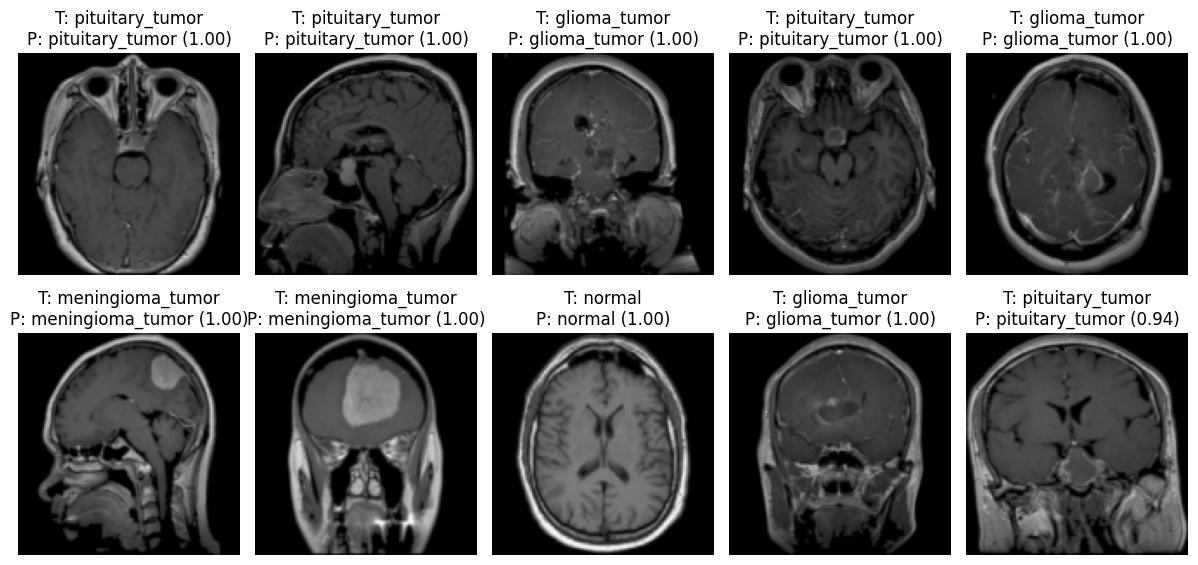

In [26]:
# Extract the first batch
inputs, labels = next(iter(test_loader))

# Perform inference (disable gradient computation for faster inference)
with torch.no_grad():
    outputs = loaded_model(inputs)  # Forward pass through the model

# Get predicted labels and probabilities
probs = torch.softmax(outputs, dim=1)  # Apply softmax to get probabilities
predictions = torch.argmax(probs, dim=1)  # Get the predicted class

# Assuming 'class_names' is a list of class names corresponding to the labels
show_images(inputs, labels, predictions, torch.max(probs, dim=1).values, class_names)